In [1]:
import sys
sys.path.append('..')

In [2]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data
import pymonad

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches, build_synonyms_graph, search_item
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio, perfect_match
from geo_annotation.import_ontology_es import import_ontology
from elasticsearch import Elasticsearch
from lib.obo import read_ontology, Ontology
pd.set_option('display.width', 512)

In [3]:
import seaborn
%matplotlib inline

In [108]:
validation_set = pd.read_pickle("../data/geo-annotation/val-larisa-tissues.py3.pickle")

In [109]:
validation_set.index = validation_set.index.map(lambda i: int(i[3:]))

In [110]:
validation_set[validation_set.classes.map(lambda c: len(c) == 0)]

,classes


In [93]:
validation_set[:10]

,classes
10245,[BTO:0000763]
10334,[BTO:0003364]
10445,[BTO:0000763]
10714,[BTO:0000271]
10810,[BTO:0000149]
10927,[BTO:0000045]
10961,[BTO:0000759]
10971,[BTO:0002402]
11001,[BTO:0000149]
11151,[BTO:0000343]


In [ ]:
# Вытаскиваем все семплы которые есть в валидационном датасете
import pymongo
db = pymongo.MongoClient().scraper_meta

In [21]:
_t =  ['GSE{}'.format(v) for v in validation_set.index]
c = db.samples.find({
        'series': {'$in': _t}
    })
sample2series = list(c)

In [23]:
sample2series = dict([(c['accession'], c['series']) for c in sample2series])

In [ ]:
sample2series = pd.DataFrame.from_records(list(sample2series.items()), columns=['sample', 'series'])

In [28]:
sample2series.head()

,sample,series
0,GSM1031004,"[GSE42038, GSE42040]"
1,GSM337226,[GSE13355]
2,GSM915156,[GSE37265]
3,GSM1233014,[GSE50948]
4,GSM523325,[GSE20916]


In [46]:
sample2series = sample2series.set_index('sample')

In [39]:
validation_set_ids = [int(x[3:]) for x in sample2series['sample'].tolist()]

In [32]:
len(validation_set_ids)

19849

In [34]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/brenda-tissue-ontology.obo',
                         exclude_duplicates=True,
                         subgraph='BTO:0001489')

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 5659
Number of edges: 6430
Average in degree:   1.1362
Average out degree:   1.1362


In [35]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [36]:
import_ontology(ontology, 'tissue_ontology')
syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'tissue_ontology'), list(ontology.items()))

In [ ]:
# search_item(client=es,
#             item=list(ontology.items())[0], 
#             index='samples', 
#             debug=True, 
#             fields=['description', 'title', 'characteristics_raw'],
#             ids=validation_set_ids[:10],)

In [41]:
annotation_result_file = '../data/geo-annotation/samples.tissue.res3.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='samples',
                         ids=validation_set_ids,
                         fields=['description', 'title', 'characteristics_raw']
                        )

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [42]:
len(res), len(validation_set_ids)

(14578, 19849)

In [111]:
# Собираем семплы в серии
res_series = (
  pd.DataFrame.from_records(  
    [(int(serie[3:]), cl) for sample_id, classes in res.classes.iteritems() 
        for cl in classes 
        for serie in sample2series.series.loc['GSM{}'.format(sample_id)]]
    , columns=['series', 'classes'])
  .drop_duplicates()
  .groupby('series')
  .classes
  .apply(lambda c: list(set(c)))
  .to_frame()  
)
res_series = res_series[res_series.index.isin(validation_set.index)]
res_series



,classes
series,
3467,[BTO:0001379]
3744,[BTO:0000149]
4183,"[BTO:0000269, BTO:0000648]"
4290,[BTO:0000142]
4757,"[BTO:0004345, BTO:0000142]"
5675,[BTO:0000142]
6004,[BTO:0001379]
6764,[BTO:0000759]
7116,"[BTO:0000553, BTO:0001025, BTO:0000878, BTO:00..."


In [74]:
def doid_id(item_id):
    return "BTO:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'BTO:0001489', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [ ]:
# cell_type_cancer = 'DOID:0050687'
# organ_system_cancer = 'DOID:0050686'
# cell_type_benign_neoplasm = 'DOID:0060084'
# organ_system_benign_neoplasm = 'DOID:0060085'

# @pymonad.curry
# def exclude_similar_branches(ontology, classes):
#     has_osc = any(ontology.has_path(organ_system_cancer, c) for c in classes)
#     if has_osc:
#         return [c for c in classes if not ontology.has_path(cell_type_cancer, c) 
# #                                       and not ontology.has_path(cell_type_benign_neoplasm, c)
# #                                       and not ontology.has_path(organ_system_benign_neoplasm, c) 
#                ]
#     else:
#         return classes

In [62]:
root_disease = 'BTO:0001489'

@pymonad.curry
def exclude_wide_terms(ontology, classes):
    threshold = 2
    
    return [c for c in classes 
            if len(nx.shortest_path(ontology.graph, root_disease, c)) > threshold]

In [112]:
results = pd.DataFrame(dict(
        odinary=res_series.classes,
        collapsed=res_series.classes.map(#exclude_wide_terms(ontology) *
                                  collapse_matches(ontology.graph)),
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
#         collapsed_syn=res.classes.map(
#                                      exclude_wide_terms(ontology) *
#                                      collapse_matches(syn_ontology.graph) *
# #                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
        
#         syn=res.classes.map(exclude_wide_terms(ontology) *
#                             collapse_matches(syn_ontology.graph)),

        validation=validation_set.classes,
        
    )
).applymap(lambda x: [] if isinstance(x, float) else x)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110d1b0b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1127d0898>]], dtype=object)

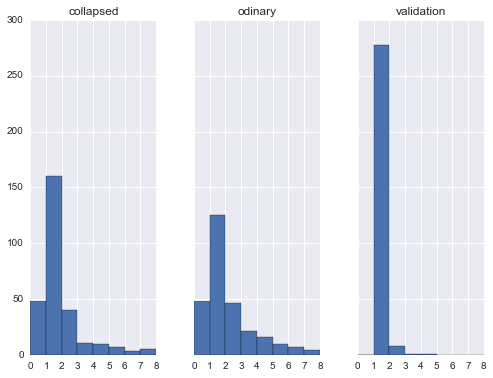

In [113]:
(
    results
    .applymap(len).hist(bins=range(0, 9), 
                        sharey=True, 
                        layout=(1, 5),
                        figsize=(14, 6))
)

In [124]:
def cell():
    t = perfect.join(results, lsuffix='_perf')
    return t[(~t.collapsed_perf) & (t.collapsed.map(lambda c: len(c)==1))]
errors = cell()

In [125]:
i = 0

1
collapsed_perf                         False
odinary_perf                            True
collapsed                      [BTO:0000641]
odinary           [BTO:0000269, BTO:0000641]
validation                     [BTO:0000271]
Name: 9452, dtype: object


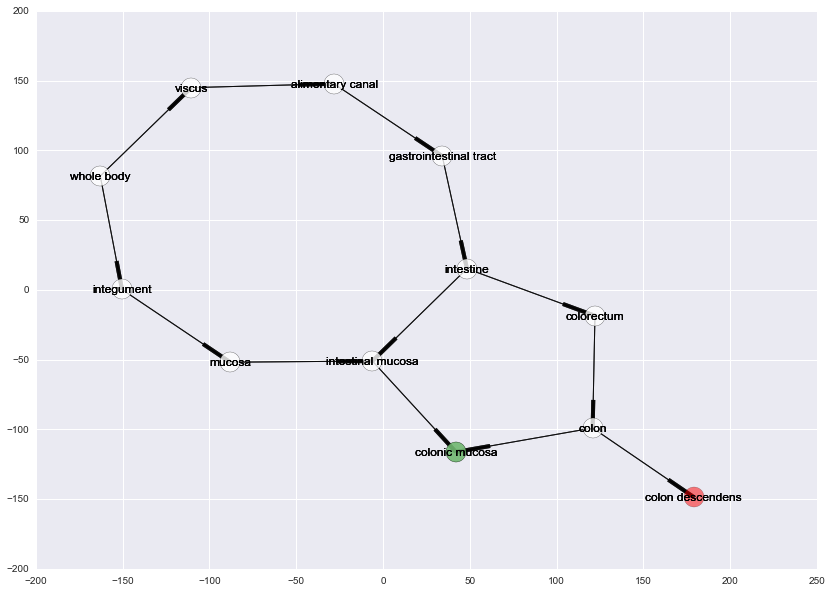

In [127]:
def cell():
    global i
    row = errors.iloc[i]
    print(i)
    print(row)
    i += 1
    matches_graph(row.collapsed, row.validation)
    
cell()

In [115]:
def compare(rc, vc):
    return ontology.has_path(rc, vc)

def compare2(rc, vc):
    return ontology.has_path(rc, vc) or ontology.has_path(vc, rc)

def compare3(rc, vc):
    threshold = 4
    if rc == vc:
        return True
    return ontology.has_path(rc, vc) and (nx.shortest_path_length(ontology.graph, rc, vc) <= threshold)
                                
def compare4(rc, vc):
    if rc == vc:
        return True
    return compare3(rc, vc) or compare3(vc, rc)

def compare0(rc, vc):
    return rc == vc


@pymonad.curry
def cr(vd, res):
    return correct_ratio(res, vd, compare_func=compare4)

@pymonad.curry
def ir(vd, res):
    return incorrect_ratio(res, vd, compare_func=compare4)


@pymonad.curry
def pm(vd, res):
    return perfect_match(res, vd, compare_func=compare4)


def cell():
    global results
    correct = pd.DataFrame(data=dict([(c, cr(results.validation, results[c])) for c in results.columns if c != 'validation']))
    incorrect = pd.DataFrame(data=dict([(c, ir(results.validation, results[c])) for c in results.columns if c != 'validation']))
    perfect = pd.DataFrame(data=dict([(c, pm(results.validation, results[c])) for c in results.columns if c != 'validation']))
    return correct, incorrect, perfect
    
correct, incorrect, perfect = cell()

## Сводная таблица

In [116]:
cols = [c for c in results.columns if c != 'validation']

counts = results.applymap(len).apply(lambda x: x.value_counts()).loc[1]
pd.DataFrame(dict(scores=[perfect.loc[results[results.validation.map(lambda x: len(x) == 1)].index].mean()[c] for c in cols],
                  counts=counts),
             index=cols).assign(range=lambda x: x['counts']/validation_set.shape[0])


,counts,scores,range
collapsed,160,0.748201,0.555556
odinary,125,0.589928,0.434028
